In [1]:
!pip install keras
!pip install tensorflow
!pip install plot_keras_history
!pip install seaborn

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.29-py3-none-any.whl size=8613 sha256=c909ecf16858205de197053404f22ec760c9a1405fc2dac0c74adb7c098c3128
  Stored in directory: /root/.cache/pip/wheels/9e/2e/42/17cb826d143226e4d081aa33d3a9b9a90f234dfcf409824b87
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=5b2482f52c8da2a16057908a0d6f436a0db16138387e08ffd4f58a1d203ab944
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4585 sha256=6b004ee82e52772a79c60101c39aac3918e44bb1f61177dc060200aa3346f4ba
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/4')


In [25]:

from keras.utils import np_utils
from keras.preprocessing import sequence

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, Reshape
from keras.layers import Input
from keras.models import Model
from keras.layers import dot
from tensorflow.keras.activations import relu
from nltk import word_tokenize, sent_tokenize
from gensim.corpora.dictionary import Dictionary
import numpy as np

from keras.preprocessing.sequence import skipgrams
import gensim
from tensorflow.keras.utils import plot_model


In [6]:
# using nltk tokenizer.  
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
#Data Preparation 

AlotOftext = """Language users never choose words randomly, and language is essentially
non-random. Statistical hypothesis testing uses a null hypothesis, which
posits randomness. Hence, when we look at linguistic phenomena in corpora, 
the null hypothesis will never be true. Moreover, where there is enough
data, we shall (almost) always be able to establish that it is not true. In
corpus studies, we frequently do have enough data, so the fact that a relation 
between two phenomena is demonstrably non-random, does not support the inference 
that it is not arbitrary. We present experimental evidence
of how arbitrary associations between word frequencies and corpora are
systematically non-random. We review literature in which hypothesis testing 
has been used, and show how it has often led to unhelpful or misleading results.""".lower()



#Tokenize text
# only tokenization is needed, no lemmatization, etc
tokenized_text = [word_tokenize(sent) for sent in sent_tokenize(AlotOftext)]

#Create Vocab as a Dictionary
vocab = Dictionary(tokenized_text)
print(dict(vocab.items()))

print(vocab.token2id['corpora'])  # get the id of the token in the vocalbulary
print(vocab[2])
sent0 = tokenized_text[0]
print(vocab.doc2idx(sent0))

vocab.add_documents([['PAD']])  # create new word, used for padding
dict(vocab.items())
print(vocab.token2id['PAD'])

corpusByWordID = list()
for sent in  tokenized_text:
    corpusByWordID.append(vocab.doc2idx(sent))

vocab_size = len(vocab)
embed_size = 100
hidden_dim=100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(vocab.items())[:10])

{0: ',', 1: '.', 2: 'and', 3: 'choose', 4: 'essentially', 5: 'is', 6: 'language', 7: 'never', 8: 'non-random', 9: 'randomly', 10: 'users', 11: 'words', 12: 'a', 13: 'hypothesis', 14: 'null', 15: 'posits', 16: 'randomness', 17: 'statistical', 18: 'testing', 19: 'uses', 20: 'which', 21: 'at', 22: 'be', 23: 'corpora', 24: 'hence', 25: 'in', 26: 'linguistic', 27: 'look', 28: 'phenomena', 29: 'the', 30: 'true', 31: 'we', 32: 'when', 33: 'will', 34: '(', 35: ')', 36: 'able', 37: 'almost', 38: 'always', 39: 'data', 40: 'enough', 41: 'establish', 42: 'it', 43: 'moreover', 44: 'not', 45: 'shall', 46: 'that', 47: 'there', 48: 'to', 49: 'where', 50: 'arbitrary', 51: 'between', 52: 'corpus', 53: 'demonstrably', 54: 'do', 55: 'does', 56: 'fact', 57: 'frequently', 58: 'have', 59: 'inference', 60: 'relation', 61: 'so', 62: 'studies', 63: 'support', 64: 'two', 65: 'are', 66: 'associations', 67: 'evidence', 68: 'experimental', 69: 'frequencies', 70: 'how', 71: 'of', 72: 'present', 73: 'systematically',

In [8]:
# Create CBOW Training data
def generate_cbow_context_word_pairs(corpusByID, window_size, vocab_size):
    context_length = window_size*2
    X=[]
    Y=[]
    for sent in corpusByID:
        sentence_length = len(sent)
        for index, word in enumerate(sent):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([sent[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)
            if start<0:
                # pre padding
                x = sequence.pad_sequences(context_words, maxlen=context_length,padding='pre',value=vocab.token2id['PAD'])
                y = np_utils.to_categorical(label_word, vocab_size)
                X.append(x)
                Y.append(y)
                continue
            if end>=sentence_length:
                # post padding
                x = sequence.pad_sequences(context_words, maxlen=context_length,padding='post',value=vocab.token2id['PAD'])
                y = np_utils.to_categorical(label_word, vocab_size)
                X.append(x)
                Y.append(y)
                continue
            else:
                X.append(sequence.pad_sequences(context_words, maxlen=context_length))
                y = np_utils.to_categorical(label_word, vocab_size)
                Y.append(y)
                continue
           
    return X,Y
            
# Test this out for some samples


X,Y = generate_cbow_context_word_pairs(corpusByWordID, window_size, vocab_size) 
   
for x, y in zip(X,Y):
    print('Context (X):', [vocab[w] for w in x[0]], '-> Target (Y):', vocab[np.argwhere(y[0])[0][0]])


Context (X): ['PAD', 'PAD', 'users', 'never'] -> Target (Y): language
Context (X): ['PAD', 'language', 'never', 'choose'] -> Target (Y): users
Context (X): ['language', 'users', 'choose', 'words'] -> Target (Y): never
Context (X): ['users', 'never', 'words', 'randomly'] -> Target (Y): choose
Context (X): ['never', 'choose', 'randomly', ','] -> Target (Y): words
Context (X): ['choose', 'words', ',', 'and'] -> Target (Y): randomly
Context (X): ['words', 'randomly', 'and', 'language'] -> Target (Y): ,
Context (X): ['randomly', ',', 'language', 'is'] -> Target (Y): and
Context (X): [',', 'and', 'is', 'essentially'] -> Target (Y): language
Context (X): ['and', 'language', 'essentially', 'non-random'] -> Target (Y): is
Context (X): ['language', 'is', 'non-random', '.'] -> Target (Y): essentially
Context (X): ['is', 'essentially', '.', 'PAD'] -> Target (Y): non-random
Context (X): ['essentially', 'non-random', 'PAD', 'PAD'] -> Target (Y): .
Context (X): ['PAD', 'PAD', 'hypothesis', 'testing']

In [11]:
cbow = Sequential()

cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: relu(K.mean(x, axis=1)), output_shape=(embed_size,)))

cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='sgd')
cbow.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            8800      
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 88)                8888      
Total params: 17,688
Trainable params: 17,688
Non-trainable params: 0
_________________________________________________________________


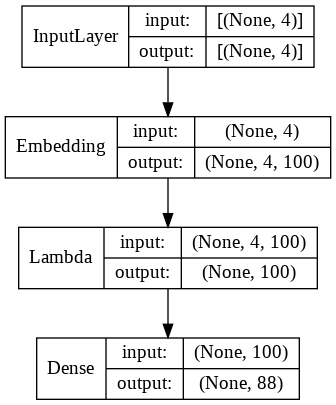

In [26]:
plot_model(cbow, 
           to_file='CBOW.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

In [13]:
#Train the model

for epoch in range(500):
    loss = 0.
    for x, y in zip(X,Y):
        loss += cbow.train_on_batch(x, y)
    print(epoch, loss)

0 554.5646358728409
1 553.6841341257095
2 552.7946840524673
3 551.8959419131279
4 550.9873014092445
5 550.0707632899284
6 549.1449193358421
7 548.2103764414787
8 547.2657839655876
9 546.310142993927
10 545.3472557067871
11 544.3746100664139
12 543.3894820213318
13 542.3951498866081
14 541.3886083960533
15 540.3719931840897
16 539.3473208546638
17 538.306388437748
18 537.2585855126381
19 536.1968170404434
20 535.1253283619881
21 534.0405678153038
22 532.9438281059265
23 531.8374236226082
24 530.7145387530327
25 529.5839214324951
26 528.4395316839218
27 527.2840823829174
28 526.1134216487408
29 524.9336965084076
30 523.7381788492203
31 522.5294053554535
32 521.3094425201416
33 520.0734116137028
34 518.8269771933556
35 517.5676866173744
36 516.294250279665
37 515.0044927597046
38 513.705759704113
39 512.393610060215
40 511.064279794693
41 509.7228732407093
42 508.3693071603775
43 507.0014007985592
44 505.61842319369316
45 504.2225660979748
46 502.8142228424549
47 501.39146730303764
48 499

In [14]:
## Save the wordvectors
f = open('Cbow_vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = cbow.get_weights()[0]
for key in vocab:
    str_vec = ' '.join(map(str, list(vectors[key, :])))
    f.write('{} {}\n'.format(vocab[key], str_vec))
f.close()

In [17]:
## Load the vectors back and validate
w2v = gensim.models.KeyedVectors.load_word2vec_format('./Cbow_vectors.txt', binary=False)

w2v.most_similar(positive=['data'])

[('do', 0.6247519850730896),
 ('frequently', 0.5282942056655884),
 ('there', 0.4254624545574188),
 ('enough', 0.35764655470848083),
 ('look', 0.28390470147132874),
 ('fact', 0.27119940519332886),
 ('when', 0.2491803765296936),
 ('have', 0.2465556561946869),
 ('shall', 0.24536146223545074),
 (',', 0.24259158968925476)]

In [18]:
#Create Skipgram Training data 

# generate skip-grams with both positive and negative examples
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=2) for sent in corpusByWordID]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
        vocab[pairs[i][0]], pairs[i][0],           
        vocab[pairs[i][1]], pairs[i][1], 
        labels[i]))

(non-random (8), always (38)) -> 0
(is (5), and (2)) -> 1
(choose (3), words (11)) -> 1
(never (7), PAD (87)) -> 0
(never (7), do (54)) -> 0
(and (2), has (76)) -> 0
(language (6), been (75)) -> 0
(language (6), never (7)) -> 1
(and (2), is (5)) -> 1
(never (7), language (6)) -> 1


In [21]:
#define the skip-gram model

input_word = Input((1,))
input_context_word = Input((1,))

word_embedding    = Embedding(input_dim=vocab_size, output_dim=embed_size,input_length=1,name='word_embedding') # w1
context_embedding = Embedding(input_dim=vocab_size, output_dim=embed_size,input_length=1,name='conotext_embedding') # w2

word_embedding = word_embedding(input_word)
word_embedding_layer = Reshape((embed_size, 1))(word_embedding)

context_embedding = context_embedding(input_context_word)
context_embedding_layer = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding_layer, context_embedding_layer], axes=1)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
outputLayer = Dense(1, activation='sigmoid')(dot_product)

model = Model(inputs=[input_word, input_context_word], outputs=outputLayer)
model.compile(loss='binary_crossentropy', optimizer='adam')

# view model summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 1, 100)       8800        input_5[0][0]                    
__________________________________________________________________________________________________
conotext_embedding (Embedding)  (None, 1, 100)       8800        input_6[0][0]                    
______________________________________________________________________________________________

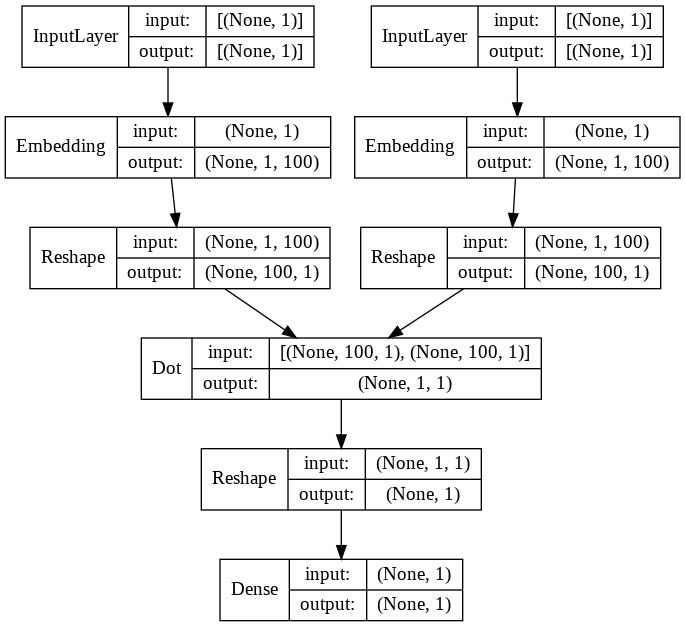

In [27]:
plot_model(model, 
           to_file='Skipgram.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

In [22]:
#train the model

for epoch in range(1, 100):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 4.853358030319214
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 4.83037805557251
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 4.809725105762482
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 4.787890791893005
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 4.763773083686829
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 6 Loss: 4.736411988735199
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 7 Loss: 4.704897403717041
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 8 Loss: 4.668373644351959
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 9 Loss: 4.626047432422638
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 10 Loss: 4.577201545238495
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 11 Loss: 4.521211206912994
Processed 0 (skip_first, skip_s

In [23]:
#get the embeding matrix
weights = model.get_weights()
## Save the wordvectors
f = open('skipgram_vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for key in vocab:
    str_vec = ' '.join(map(str, list(vectors[key, :])))
    f.write('{} {}\n'.format(vocab[key], str_vec))
f.close()

In [24]:
## Load the vectors back and validate
w2v = gensim.models.KeyedVectors.load_word2vec_format('./skipgram_vectors.txt', binary=False)
w2v.most_similar(positive=['data'])


[('be', 0.44149768352508545),
 ('null', 0.3881838321685791),
 ('there', 0.3713914453983307),
 ('the', 0.3272995352745056),
 ('where', 0.32107824087142944),
 ('do', 0.30284181237220764),
 ('not', 0.28916043043136597),
 ('enough', 0.2754952311515808),
 ('fact', 0.2703453004360199),
 ('frequently', 0.2650138735771179)]

In [ ]:
#Excerise: 
#modeify the skipegram_model to share the same embeding layer between word and context
#Discussion: which is better? Why?  

In [31]:
input_word = Input((1,))
input_context_word = Input((1,))

shared_embedding = Embedding(input_dim=vocab_size, output_dim=embed_size,input_length=1) 


word_embedding = shared_embedding(input_word)
word_embedding_layer = Reshape((embed_size, 1))(word_embedding)

context_embedding = shared_embedding(input_context_word)
context_embedding_layer = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding_layer, context_embedding_layer], axes=1)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
outputLayer = Dense(1, activation='sigmoid')(dot_product)

model_shared_embedding = Model(inputs=[input_word, input_context_word], outputs=outputLayer)
model_shared_embedding.compile(loss='binary_crossentropy', optimizer='adam')

# view model summary
print(model_shared_embedding.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       8800        input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 100, 1)       0           embedding_2[0][0]          

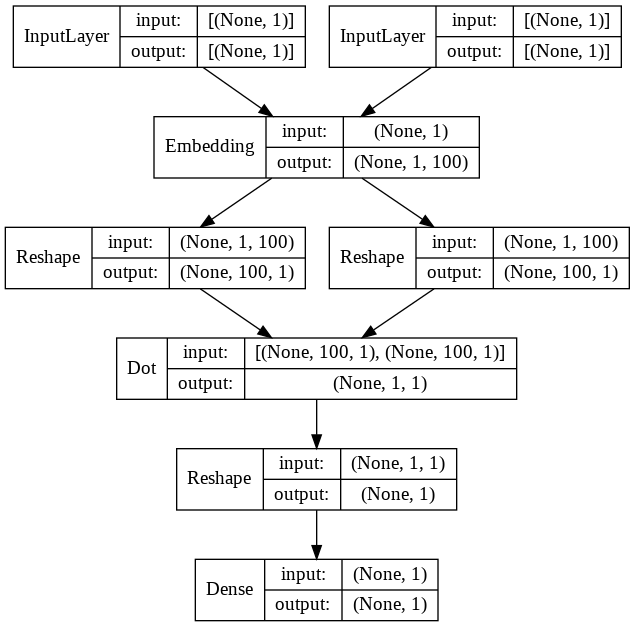

In [33]:
plot_model(model_shared_embedding, 
           to_file='Skipgram_shared_embedding.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

In [35]:

for epoch in range(1, 100):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model_shared_embedding.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)


#get the embeding matrix
weights = model_shared_embedding.get_weights()
## Save the wordvectors
f = open('skipgram_vectors_shared_embedding.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model_shared_embedding.get_weights()[0]
for key in vocab:
    str_vec = ' '.join(map(str, list(vectors[key, :])))
    f.write('{} {}\n'.format(vocab[key], str_vec))
f.close()

## Load the vectors back and validate
w2v = gensim.models.KeyedVectors.load_word2vec_format('./skipgram_vectors_shared_embedding.txt', binary=False)
w2v.most_similar(positive=['data'])

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 4.852792859077454
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 4.8348440527915955
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 4.818501114845276
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 4.8007296323776245
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 4.7806121706962585
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 6 Loss: 4.757333874702454
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 7 Loss: 4.7301188707351685
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 8 Loss: 4.698233962059021
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 9 Loss: 4.66100287437439
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 10 Loss: 4.6178224086761475
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 11 Loss: 4.5681793093681335
Processed 0 (skip_first, 

[('enough', 0.7755709886550903),
 ('have', 0.5805065631866455),
 ('we', 0.4833280146121979),
 ('do', 0.4384659230709076),
 ('is', 0.38403600454330444),
 ('present', 0.3517614006996155),
 ('studies', 0.3416319489479065),
 ('does', 0.34022796154022217),
 ('experimental', 0.3254093527793884),
 ('look', 0.2884720265865326)]

**Conclusion?**   
Cannot really tell anything   
Corpus is too small to comment on the performance of 2 approaches   